In [1]:
# import pandas as pd
import pandas as pd
import numpy as np

In [2]:
# relevant columns
columns = '''Year
Month
DayofMonth
DayOfWeek
FlightDate
Reporting_Airline
Origin
Dest
DepTime
DepDelay
DepDelayMinutes
DepDel15
DepTimeBlk
ArrDelay
ArrDelayMinutes
ArrDel15
ArrTimeBlk
Cancelled
Tail_Number
ArrTime
AirTime
CarrierDelay
WeatherDelay
NASDelay
SecurityDelay
LateAircraftDelay
CancellationCode
'''

features = columns.split()

filtered_df = pd.DataFrame()

# read in all data and save out SFO -> LAX

# dtypes = {
#     'DepTime' : int,
#     'DepDel15': int,
#     'ArrDel15': int,
#     'Cancelled' : int
# }

# chunksize = 10**6
# with pd.read_csv('data/airline.csv',
#                     # usecols=features,
#                     encoding='unicode_escape',
#                     chunksize=chunksize) as reader:
#     for chunk in reader:
#         filter = (chunk['Origin'] == 'SFO') & (chunk['Dest'] == 'LAX') & (chunk['Year'] >= 2010)
#         filtered_df = pd.concat([filtered_df, chunk[filter]])
#         print('row {}/200000000'.format(chunk.iloc[0].name))

# filtered_df.to_csv('data/airline_filtered.csv', encoding='utf-8', index=False)

get all flights with origin OR destination as lax or sfo:

In [3]:
# filtered_df = pd.DataFrame()

# chunksize = 10**6
# with pd.read_csv('data/airline.csv',
#                     usecols=features,
#                     encoding='unicode_escape',
#                     chunksize=chunksize) as reader:
#     for chunk in reader:
#         filter = ((chunk['Origin'] == 'SFO') | (chunk['Origin'] == 'LAX') | (chunk['Dest'] == 'SFO') | (chunk['Dest'] == 'LAX')) & (chunk['Year'] >= 2010)
#         filtered_df = pd.concat([filtered_df, chunk[filter]])
#         print('{:2f}% done'.format(chunk.iloc[0].name/200000000*100))

# filtered_df.to_csv('data/airline_total_sfo_lax_data.csv', encoding='utf-8', index=False)  

In [4]:
df_main = pd.read_csv('data/airline_filtered.csv', usecols=features)
df_all = pd.read_csv('data/airline_total_sfo_lax_data.csv')
print(df_main.shape, df_all.shape)

(154511, 27) (7498736, 27)


Convert flight date to datetime:

In [5]:
# drop missing vals
df_main = df_main.dropna(subset=['DepTime', 'ArrTime', 'FlightDate'])
df_main = df_main[ (df_main['DepTime'] < 2400) & (df_main['ArrTime'] < 2400) ]
df_main['FlightDate'] = df_main['FlightDate'] + ' ' + df_main['DepTime'].astype(int).astype(str).str.zfill(4)
df_main['FlightDate'] = pd.to_datetime(df_main['FlightDate'], format='%Y-%m-%d %H%M')

df_all = df_all.dropna(subset=['DepTime', 'ArrTime', 'FlightDate'])
df_all = df_all[ (df_all['DepTime'] < 2400) & (df_all['ArrTime'] < 2400) ]
df_all['FlightDate'] = df_all['FlightDate'] + ' ' + df_all['DepTime'].astype(int).astype(str).str.zfill(4)
df_all['FlightDate'] = pd.to_datetime(df_all['FlightDate'], format='%Y-%m-%d %H%M')

# sort and reset index
df_main = df_main.sort_values('FlightDate')
df_main.reset_index(drop=True, inplace=True)
df_all = df_all.sort_values('FlightDate')
df_all.reset_index(drop=True, inplace=True)

Brute force approach: too slow

In [6]:
# df_main['SFODepDelRate'] = 0.
# df_main['LAXDepDelRate'] = 0.
# df_main['SFOArrDelRate'] = 0.
# df_main['LAXArrDelRate'] = 0.

# min_idx = 0
# window_size = 1000000000
# for i in range(df_main.shape[0]):
#     # filter by time
#     hr_low = 6
#     hr_high = 4
#     delta = df_main['FlightDate'].iloc[i] - df_all['FlightDate'].iloc[min_idx:min_idx + window_size]
#     mask = (delta.dt.total_seconds() > hr_high*3600) & (delta.dt.total_seconds() < hr_low*3600)
            
#     if mask.sum() != 0:
        
#         # first index that starts the relevant values to save for next time
#         min_idx = mask[ mask == True].index[0]
#         window_size = 400
    
#         df_main.at[i, 'SFODepDelRate'] = df_all.iloc[mask[mask == True].index].loc[df_all['Origin']=='SFO']['DepDel15'].mean()
#         df_main.at[i, 'LAXDepDelRate'] = df_all.iloc[mask[mask == True].index].loc[df_all['Origin']=='LAX']['DepDel15'].mean()
#         df_main.at[i, 'SFOArrDelRate'] = df_all.iloc[mask[mask == True].index].loc[df_all['Origin']=='SFO']['ArrDel15'].mean()
#         df_main.at[i, 'LAXArrDelRate'] = df_all.iloc[mask[mask == True].index].loc[df_all['Origin']=='LAX']['ArrDel15'].mean()
        
#     else:
#         # widen search window if previous found no values
#         min_idx += 1
#         window_size = 10000
#         print('no vals:', i, min_idx, df_main.iloc[i]['FlightDate'])

    
#     # df_main.at[i, 'LAXDepDelRate'] = df_all[ mask & (df_all['Origin']=='LAX')]['DepDel15'].mean()
#     # df_main.at[i, 'SFOArrDelRate'] = df_all[ mask & (df_all['Origin']=='SFO')]['ArrDel15'].mean()
#     # df_main.at[i, 'LAXArrDelRate'] = df_all[ mask & (df_all['Origin']=='LAX')]['ArrDel15'].mean()
    
#     if i % 10 == 0:
#         print('record', i)


# Look as distribution of the times $n$ number of points before

# start = 5000000
# n = 400
# m = np.random.randint(n+1, 900000, 1000)
# d = []
# for i in range(1000):
#     t = (df_all['FlightDate'].iloc[m[i]] - df_all['FlightDate'].iloc[m[i]-n])
#     t = t.total_seconds()/3600
#     d.append(t)
# plt.hist(d, bins=20)

In [101]:
# columns to contain delay rates of previous flights
rate_cols = ['SFODepDelRate', 'LAXDepDelRate', 'SFOArrDelRate', 'LAXArrDelRate']
df_all[rate_cols] = 0.

# shift back hr_before_dep hours to make end of window
hr_before_dep = 6
window = '1h'
df_aux = df_all[['FlightDate', 'Origin', 'Dest', 'DepDel15', 'ArrDel15']].copy()
df_aux['FlightDate'] += pd.Timedelta(hr_before_dep, unit='h')

In [102]:
# calculate % delayed in timewindow of (-hr_before_depature - 2, -hr_before_departure)
# df_aux['SFODepDelRate'] = df_aux[df_aux['Origin'] == 'SFO'].rolling(window, min_periods=1, on='FlightDate', center=False)['DepDel15'].mean()
# df_aux['LAXDepDelRate'] = df_aux[df_aux['Origin'] == 'LAX'].rolling(window, min_periods=1, on='FlightDate', center=False)['DepDel15'].mean()
# df_aux['SFOArrDelRate'] = df_aux[df_aux['Dest'] == 'SFO'].rolling(window, min_periods=1, on='FlightDate', center=False)['ArrDel15'].mean()
# df_aux['LAXArrDelRate'] = df_aux[df_aux['Dest'] == 'LAX'].rolling(window, min_periods=1, on='FlightDate', center=False)['ArrDel15'].mean()

# using exponential weighted mean
halflife = '1h'
df_aux['SFODepDelRate'] = df_aux[df_aux['Origin'] == 'SFO']['DepDel15'].ewm(times=df_aux[df_aux['Origin'] == 'SFO']['FlightDate'], halflife=halflife).mean()
df_aux['LAXDepDelRate'] = df_aux[df_aux['Origin'] == 'LAX']['DepDel15'].ewm(times=df_aux[df_aux['Origin'] == 'LAX']['FlightDate'], halflife=halflife).mean()
df_aux['SFOArrDelRate'] = df_aux[df_aux['Dest'] == 'SFO']['ArrDel15'].ewm(times=df_aux[df_aux['Dest'] == 'SFO']['FlightDate'], halflife=halflife).mean()
df_aux['LAXArrDelRate'] = df_aux[df_aux['Dest'] == 'LAX']['ArrDel15'].ewm(times=df_aux[df_aux['Dest'] == 'LAX']['FlightDate'], halflife=halflife).mean()

In [103]:
# round times to nearest hour for merge
df_aux['RoundFlightDate'] = df_aux['FlightDate'].dt.round('h')
df_main['RoundFlightDate'] = df_main['FlightDate'].dt.round('h')

In [104]:
# do merges

df_main = df_main.merge(
    df_aux[df_aux['Origin'] == 'SFO'][['RoundFlightDate', 'SFODepDelRate']].drop_duplicates(subset='RoundFlightDate'),
    on='RoundFlightDate',
    how='left'
)

df_main = df_main.merge(
    df_aux[df_aux['Origin'] == 'LAX'][['RoundFlightDate', 'LAXDepDelRate']].drop_duplicates(subset='RoundFlightDate'),
    on='RoundFlightDate',
    how='left'
)

df_main = df_main.merge(
    df_aux[df_aux['Dest'] == 'SFO'][['RoundFlightDate', 'SFOArrDelRate']].drop_duplicates(subset='RoundFlightDate'),
    on='RoundFlightDate',
    how='left'
)

df_main = df_main.merge(
    df_aux[df_aux['Dest'] == 'LAX'][['RoundFlightDate', 'LAXArrDelRate']].drop_duplicates(subset='RoundFlightDate'),
    on='RoundFlightDate',
    how='left'
)

About 15 - 20% of values of NA (pretty good)

In [105]:
df_main[['FlightDate'] + rate_cols].isna().mean()

FlightDate       0.000000
SFODepDelRate    0.175233
LAXDepDelRate    0.151843
SFOArrDelRate    0.232844
LAXArrDelRate    0.213125
dtype: float64

Replaces NAN rates with 0

In [106]:
df_main[rate_cols] = df_main[rate_cols].fillna(0.)

Save data:


In [107]:
df_main.to_csv('data/airlines_filtered_selected_with_weather_and_delayrates.csv', encoding='utf-8', index=False)

In [108]:
df_main[['ArrDel15'] + rate_cols].corr()

,ArrDel15,SFODepDelRate,LAXDepDelRate,SFOArrDelRate,LAXArrDelRate
ArrDel15,1.000000,0.152496,0.101803,0.223675,0.132719
SFODepDelRate,0.152496,1.000000,0.574579,0.596424,0.408601
LAXDepDelRate,0.101803,0.574579,1.000000,0.396079,0.517643
SFOArrDelRate,0.223675,0.596424,0.396079,1.000000,0.428615
LAXArrDelRate,0.132719,0.408601,0.517643,0.428615,1.000000


## Sanity check

Make sure that rates calculated by rolling window are similar to the manual calculation (they are)

In [109]:
df_main[rate_cols].iloc[10000:10010]

,SFODepDelRate,LAXDepDelRate,SFOArrDelRate,LAXArrDelRate
10000,0.136248,0.025980,0.046455,0.016555
10001,0.099083,0.037285,0.024942,0.009045
10002,0.099083,0.037285,0.024942,0.009045
10003,0.137368,0.055071,0.074976,0.053829
10004,0.144778,0.031912,0.159916,0.074896
10005,0.073133,0.074888,0.274992,0.147137
10006,0.416420,0.093574,0.000000,0.000000
10007,0.416420,0.093574,0.000000,0.000000
10008,0.000000,0.068124,0.000000,0.000000
10009,0.000000,0.068124,0.000000,0.000000


In [110]:
t = df_main['RoundFlightDate'].iloc[10004]
df_all[ (df_all['FlightDate'] <= t - pd.Timedelta(6, 'h')) & \
    (df_all['FlightDate'] >= t-pd.Timedelta(8, 'h')) &\
    (df_all['Dest'] == 'LAX')]['ArrDel15'].mean()

0.11290322580645161

(array([6.6891e+04, 3.9960e+04, 2.3566e+04, 1.1396e+04, 4.6980e+03,
        2.2130e+03, 9.0900e+02, 3.1800e+02, 1.3100e+02, 2.7000e+01]),
 array([0.        , 0.09782086, 0.19564171, 0.29346257, 0.39128343,
        0.48910429, 0.58692514, 0.684746  , 0.78256686, 0.88038772,
        0.97820857]),
 <BarContainer object of 10 artists>)

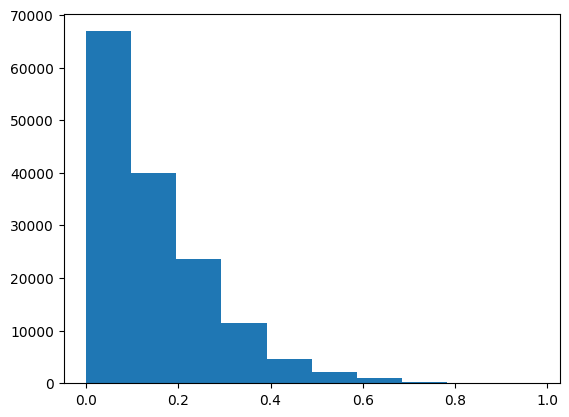

In [111]:
import matplotlib.pyplot as plt
plt.hist(df_main['LAXDepDelRate'])